In [29]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, MaxPool2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical


In [2]:
base_dir =  '../hotdog-nothotdog/'


def load_images_and_labels(category, label, data_type='train'):
    images = []
    labels = []
    path = os.path.join(base_dir, data_type, category)
    for file in os.listdir(path):
        img_path = os.path.join(path, file)
        img = load_img(img_path, target_size=(224, 224))  # 224x224 for MobileNetV2
        img = img_to_array(img)
        img = img / 255.0  # Normalize to [0, 1]
        images.append(img)
        if data_type == 'train':  # Only add labels for training data
            labels.append(label)
    return images, labels

In [31]:
# Load all training images
hotdog_images, hotdog_labels = load_images_and_labels('hotdog', 1)
nothotdog_images, nothotdog_labels = load_images_and_labels('nothotdog', 0)

# Combine and shuffle
train_images = np.array(hotdog_images + nothotdog_images)
train_labels = np.array(hotdog_labels + nothotdog_labels)

# Use train_test_split to create the validation data
train_images, valid_images, train_labels, valid_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42)

# Load and configure the MobileNetV2 model for fine-tuning
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze layers

Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.8122 - loss: 0.4121 - val_accuracy: 0.9069 - val_loss: 0.2706
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.8991 - loss: 0.2247 - val_accuracy: 0.9164 - val_loss: 0.2381
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.9094 - loss: 0.2278 - val_accuracy: 0.8963 - val_loss: 0.2430
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.9308 - loss: 0.1673 - val_accuracy: 0.9176 - val_loss: 0.2296
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.9535 - loss: 0.1343 - val_accuracy: 0.9058 - val_loss: 0.2996
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9547 - loss: 0.1223 - val_accuracy: 0.9176 - val_loss: 0.2439
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.9432 - loss: 0.1346 - val_accuracy: 0.9305 - val_loss: 0.2365
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 97s 900ms/step - accuracy: 0.9522 - loss: 0.1260 - val_ac

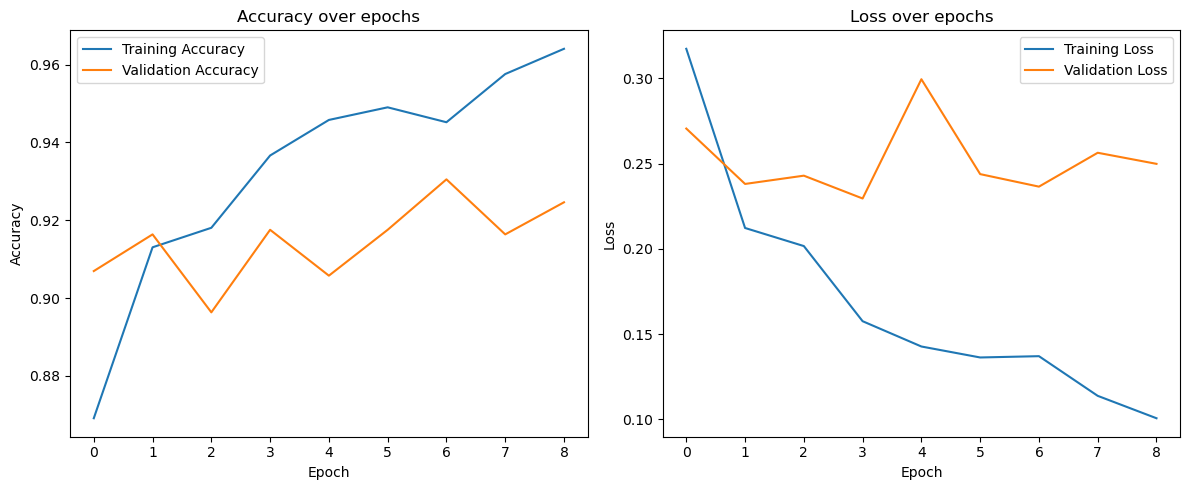

13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 768ms/step


In [32]:


# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model
history = model.fit(train_images, train_labels, epochs=50, batch_size=32,
                    validation_data=(valid_images, valid_labels),
                    callbacks=[early_stopping])

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Prepare the test data
test_hotdog_images, _ = load_images_and_labels('hotdog', None, 'test')
test_nothotdog_images, _ = load_images_and_labels('nothotdog', None, 'test')
test_images = np.array(test_hotdog_images + test_nothotdog_images)
test_images_cnn = test_images.reshape((-1, 224, 224, 3))

# Predict on the test set
test_predictions = model.predict(test_images_cnn)
test_predicted_labels = (test_predictions > 0.5).astype(int).reshape(-1)



In [33]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,504,133 (9.55 MB)

 Trainable params: 82,049 (320.50 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 164,100 (641.02 KB)

In [34]:
model.save('../Models/my_model.keras')

In [7]:
model.save('../Models/MobileNet_test.h5')

ValueError: Unable to create dataset (name already exists)

In [ ]:
#save model
import pickle
filename = "/content/drive/MyDrive/hotdog-nothotdog/updated_mobilenet.sav"
with open('model.sav', 'wb') as f:
    pickle.dump(model, f)


# New section

testing 

In [14]:
test_pic = '../hotdog-nothotdog/test/nothotdog'

In [17]:
def preprocess_image(image):
    # Resize the image to match the input size of your CNN model
    image = image.resize((224, 224))  # Assuming your model expects 224x224 input
    # Convert the image to a numpy array
    image_array = img_to_array(image)
    # Normalize the pixel values to be in the range [0, 1]
    image_array = image_array / 255.0
    # Expand the dimensions to create a batch of size 1
    image_array = np.expand_dims(image_array, axis=0)
    return image_array



In [24]:
img_path = os.path.join(test_pic, '51368.jpg')
img = load_img(img_path, target_size=(224, 224)) 

In [25]:
preprocessed_image = preprocess_image(img)

In [26]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze layers
pred = model.predict(preprocessed_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


In [27]:
pred[0][0]

0.17476153